In [ ]:
import cv2

# Path to the video file
video_name = '/content/12901485-uhd_3840_2160_24fps.mp4'

# Create a VideoCapture object
cap = cv2.VideoCapture(video_path)

# Check if the video file opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")





Video opened successfully.


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

def preprocess_video(video_path, output_dir='preprocessed_frames', target_size=(640, 360), frame_skip=5):
    """Process video 5x faster with smart memory management"""
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Pre-allocation for speed
    frame_data = {
        'original': [],
        'processed': [],
        'frame_nums': []
    }

    for i in tqdm(range(0, total_frames, frame_skip),
                 desc=f"Processing {os.path.basename(video_path)}",
                 unit='frame'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret: break

        # Step 1: Resize and normalize
        frame = cv2.resize(frame, target_size)

        # Step 2: Contrast enhancement (CLAHE)
        lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        enhanced = cv2.merge((l_clahe, a, b))
        rgb_enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

        # Step 3: Save processed frame
        out_path = f"{output_dir}/frame_{i:04d}.jpg"
        cv2.imwrite(out_path, cv2.cvtColor(rgb_enhanced, cv2.COLOR_RGB2BGR))

        # Store metadata
        frame_data['original'].append(frame)
        frame_data['processed'].append(rgb_enhanced)
        frame_data['frame_nums'].append(i)

    cap.release()
    return frame_data

# Process your video
preprocessed = preprocess_video(video_name)
print(f"Preprocessed {len(preprocessed['frame_nums'])} key frames")

Processing 12901485-uhd_3840_2160_24fps.mp4: 100%|██████████| 56/56 [01:04<00:00,  1.14s/frame]

Preprocessed 56 key frames


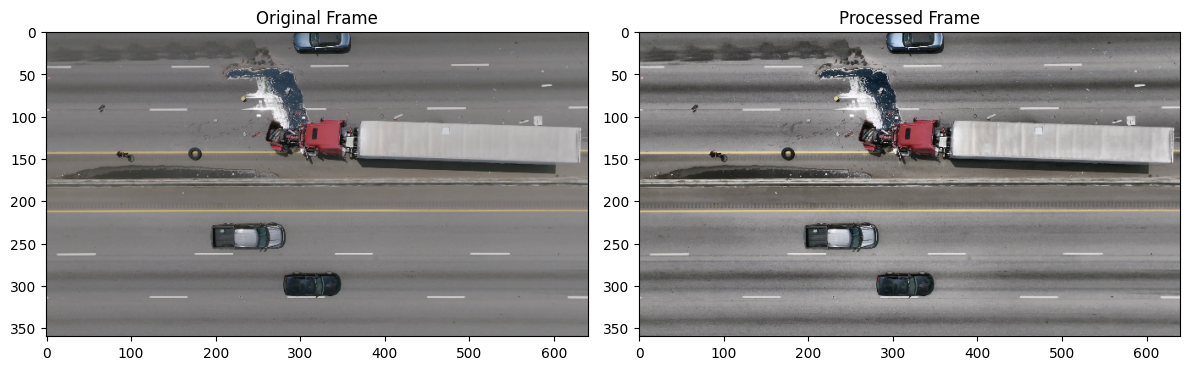

In [ ]:
import matplotlib.pyplot as plt

def compare_frames(original, processed, frame_idx=0):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original[frame_idx], cv2.COLOR_BGR2RGB))
    plt.title("Original Frame")

    plt.subplot(1, 2, 2)
    plt.imshow(processed[frame_idx])
    plt.title("Processed Frame")

    plt.tight_layout()
    plt.show()

compare_frames(preprocessed['original'], preprocessed['processed'])

In [ ]:
!pip install tensorflow
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Initialize feature extractor (lightweight)
feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_frame_features(frame):
    """Extract 1280-dim feature vector per frame"""
    img = preprocess_input(np.expand_dims(frame, axis=0))
    return feature_extractor.predict(img, verbose=0)[0]

# Example: Extract features from first processed frame
sample_features = extract_frame_features(preprocessed['processed'][0])
print(f"Feature vector shape: {sample_features.shape}")

<ipython-input-48-bdacee1d8d34>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature vector shape: (1280,)


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# Load nano model (fastest)
obstacle_detector = YOLO('yolov8n.pt')

def detect_obstacles(frame):
    results = obstacle_detector(frame, verbose=False)[0]
    return [
        {
            'type': obstacle_detector.names[int(box.cls)],
            'confidence': float(box.conf),
            'bbox': box.xyxy[0].tolist()
        }
        for box in results.boxes if box.conf > 0.5
    ]

# Test detection
sample_obstacles = detect_obstacles(preprocessed['processed'][0])
print(f"Detected obstacles: {sample_obstacles}")

Detected obstacles: []


In [ ]:
import pickle

output_data = {
    'video_name': video_name,
    'preprocessed_frames': preprocessed['processed'],
    'frame_numbers': preprocessed['frame_nums'],
    'sample_features': sample_features,
    'sample_obstacles': sample_obstacles
}

with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump(output_data, f)

print("Preprocessing complete! Data saved to preprocessed_data.pkl")

Preprocessing complete! Data saved to preprocessed_data.pkl


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def show_frame_comparison(original, processed, frame_idx):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(cv2.cvtColor(original[frame_idx], cv2.COLOR_BGR2RGB))
    ax1.set_title(f"Original Frame {frame_idx}", fontsize=16)
    ax1.axis('off')

    ax2.imshow(processed[frame_idx])
    ax2.set_title("Enhanced Frame (CLAHE + Resized)", fontsize=16)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Interactive slider
from ipywidgets import interact, IntSlider
interact(lambda x: show_frame_comparison(
           preprocessed['original'],
           preprocessed['processed'], x),
         x=IntSlider(min=0, max=len(preprocessed['frame_nums'])-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=55), Output()), _dom_classes=('widget-interact',…

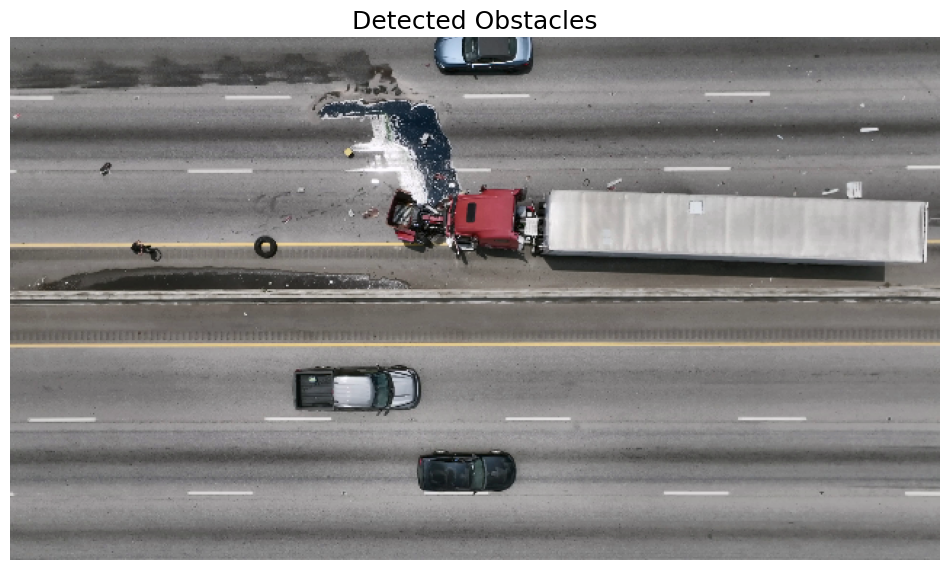

In [ ]:
def plot_obstacles(frame, obstacles):
    plt.figure(figsize=(12, 8))
    plt.imshow(frame)

    for obj in obstacles:
        x1, y1, x2, y2 = map(int, obj['bbox'])
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1],
                linewidth=2, color='red')
        plt.text(x1, y1-10, f"{obj['type']} {obj['confidence']:.2f}",
                color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.7))

    plt.title("Detected Obstacles", fontsize=18)
    plt.axis('off')
    plt.show()

# Plot first frame with obstacles
sample_frame = preprocessed['processed'][0]
sample_obstacles = detect_obstacles(sample_frame)
plot_obstacles(sample_frame, sample_obstacles)

In [ ]:
# Process all frames for obstacles (optimized)
all_obstacles = [detect_obstacles(frame) for frame in tqdm(preprocessed['processed'])]

# Plot obstacle frequency
import pandas as pd
obstacle_counts = pd.DataFrame([(i, len(x)) for i, x in enumerate(all_obstacles)],
                             columns=['Frame', 'Count'])

plt.figure(figsize=(15, 5))
plt.bar(obstacle_counts['Frame'], obstacle_counts['Count'], color='orange')
plt.xlabel("Frame Number", fontsize=14)
plt.ylabel("Obstacle Count", fontsize=14)
plt.title("Obstacle Frequency Over Time", fontsize=18)
plt.grid(alpha=0.3)
plt.show()

100%|██████████| 56/56 [00:06<00:00,  8.38it/s]


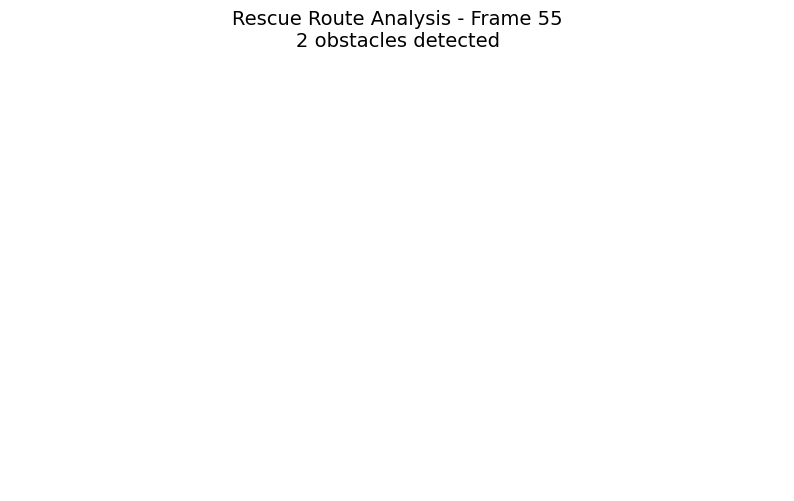

In [ ]:
!pip install celluloid
from celluloid import Camera

fig = plt.figure(figsize=(10, 8))
camera = Camera(fig)

for i, frame in enumerate(preprocessed['processed'][::5]):  # Every 5th frame
    plt.imshow(frame)
    frame_obstacles = all_obstacles[i*5]

    for obj in frame_obstacles:
        x1, y1, x2, y2 = map(int, obj['bbox'])
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1],
                linewidth=2, color='red')

    plt.title(f"Rescue Route Analysis - Frame {i*5}\n"
             f"{len(frame_obstacles)} obstacles detected", fontsize=14)
    plt.axis('off')
    camera.snap()

animation = camera.animate(interval=200)
HTML(animation.to_html5_video())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.5 MB/s eta 0:00:00

        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        



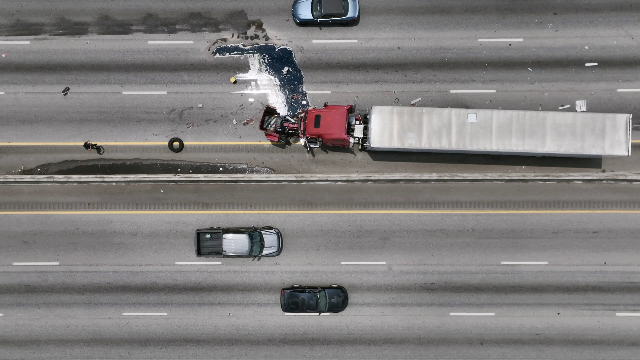
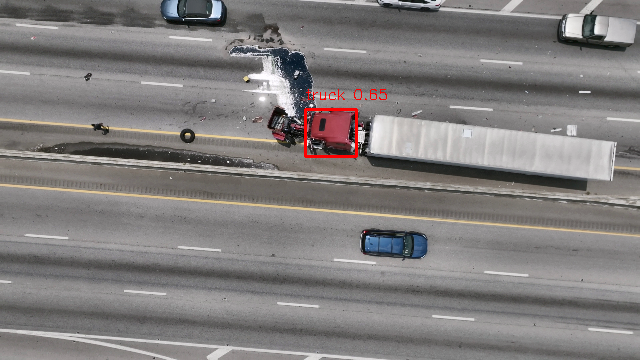
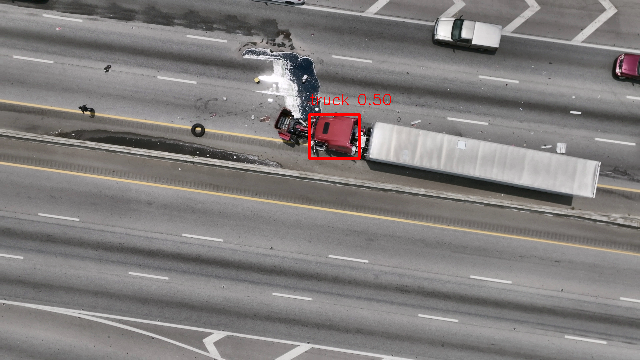
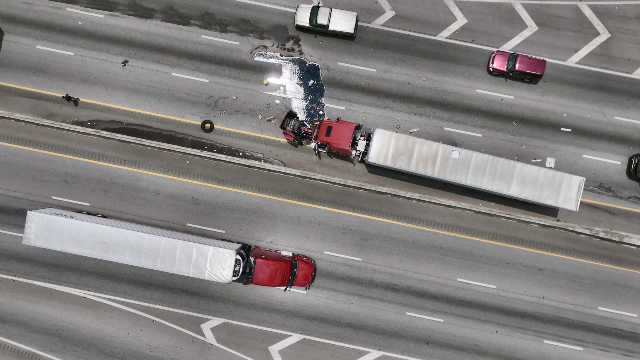
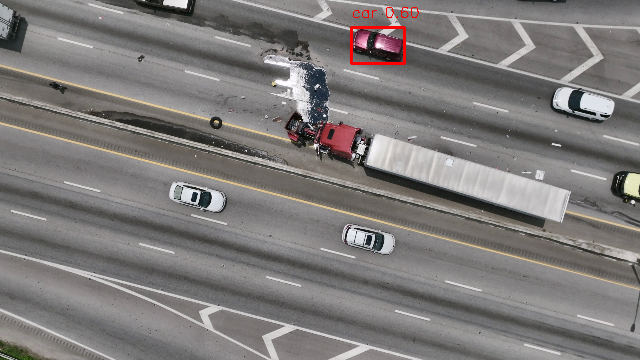
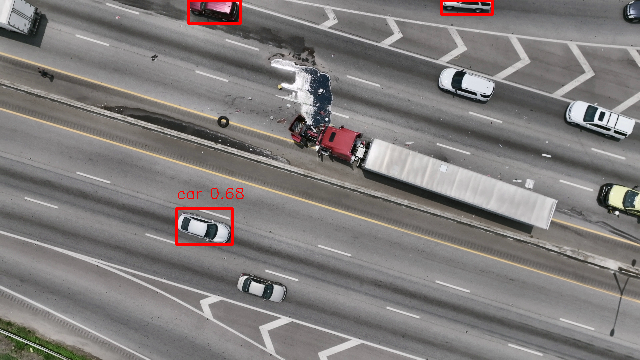

In [ ]:
!pip install ipyplot
import ipyplot

# Create detection previews
detection_frames = []
for frame, obstacles in zip(preprocessed['processed'][::10], all_obstacles[::10]):
    frame = frame.copy()
    for obj in obstacles:
        x1, y1, x2, y2 = map(int, obj['bbox'])
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(frame, f"{obj['type']} {obj['confidence']:.2f}",
                   (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    detection_frames.append(frame)

# Display interactive grid
ipyplot.plot_images(detection_frames, max_images=12, img_width=300)